In [92]:
!pip install playwright
!playwright install chromium

In [93]:
import asyncio
from playwright.async_api import async_playwright
from bs4 import BeautifulSoup
import pandas as pd

async def crawl_fpt_vietstock():
    async with async_playwright() as p:
        browser = await p.chromium.launch(headless=True)
        page = await browser.new_page()
        await page.goto('https://finance.vietstock.vn/FPT-ctcp-fpt.htm?tab=BCTC')
        await page.wait_for_timeout(5000)

        content = await page.content()
        await browser.close()

        soup = BeautifulSoup(content, 'html.parser')
        table_divs = soup.find_all('div', class_='table-responsive')

        all_tables = {}
        for idx, table_div in enumerate(table_divs):
            table = table_div.find('table')
            if not table:
                continue

            title_tag = table.find('span', class_='h4')
            table_title = title_tag.get_text(strip=True) if title_tag else f"Bảng {idx+1}"

            headers = []
            thead = table.find('thead')
            if thead:
                header_row = thead.find_all('th')
                headers = [th.get_text(strip=True) for th in header_row]

            data = []
            tbody = table.find('tbody')
            if tbody:
                for row in tbody.find_all('tr'):
                    cols = [td.get_text(strip=True).replace(',', '').replace('.', '').replace('\xa0', '') for td in row.find_all(['td', 'th'])]
                    data.append(cols)

            if data:
                max_cols = max(len(row) for row in data)
                if len(headers) != max_cols:
                    headers = [f"Column {i+1}" for i in range(max_cols)]
                df = pd.DataFrame(data, columns=headers)
                all_tables[table_title] = df

        # 🔍 Chỉ giữ lại 3 bảng tài chính
        selected_keys = ['Kết quả kinh doanh', 'Cân đối kế toán', 'Chỉ số tài chính']
        filtered_tables = {key: all_tables[key] for key in selected_keys if key in all_tables}

        for key, df in filtered_tables.items():
            print(f"\n====== {key} ======")
            print(df)

        return filtered_tables

# Gọi
await crawl_fpt_vietstock()



====== Kết quả kinh doanh ======
   Kết quả kinh doanh Quý 2/202401/04-30/06CKT/HN Quý 3/202401/07-30/09CKT/HN  \
0     Doanh thu thuần                    15245226                    15902822   
1       Lợi nhuận gộp                     5651357                     6158956   
2    LN thuần từ HĐKD                     2635781                     2948226   
3    LNST thu nhập DN                     2283041                     2478598   
4  LNST của CĐ cty mẹ                     1873815                     2088852   

  Quý 4/202401/10-31/12CKT/HN Quý 1/202501/01-31/03CKT/HN  
0                    17607818                    16058141  
1                     6478973                     6301348  
2                     2922047                     2993843  
3                     2493502                     2595557  
4                     2086993                     2174301  

====== Cân đối kế toán ======
    Cân đối kế toán Quý 2/202401/04-30/06CKT/HN Quý 3/202401/07-30/09CKT/HN  \
0  Tài sả

{'Kết quả kinh doanh':    Kết quả kinh doanh Quý 2/202401/04-30/06CKT/HN Quý 3/202401/07-30/09CKT/HN  \
 0     Doanh thu thuần                    15245226                    15902822   
 1       Lợi nhuận gộp                     5651357                     6158956   
 2    LN thuần từ HĐKD                     2635781                     2948226   
 3    LNST thu nhập DN                     2283041                     2478598   
 4  LNST của CĐ cty mẹ                     1873815                     2088852   
 
   Quý 4/202401/10-31/12CKT/HN Quý 1/202501/01-31/03CKT/HN  
 0                    17607818                    16058141  
 1                     6478973                     6301348  
 2                     2922047                     2993843  
 3                     2493502                     2595557  
 4                     2086993                     2174301  ,
 'Cân đối kế toán':     Cân đối kế toán Quý 2/202401/04-30/06CKT/HN Quý 3/202401/07-30/09CKT/HN  \
 0  Tài sản ngắn h

## Khai báo các df để phân tích


In [94]:
# Gọi và lấy kết quả từ hàm crawl
tables = await crawl_fpt_vietstock()



====== Kết quả kinh doanh ======
   Kết quả kinh doanh Quý 2/202401/04-30/06CKT/HN Quý 3/202401/07-30/09CKT/HN  \
0     Doanh thu thuần                    15245226                    15902822   
1       Lợi nhuận gộp                     5651357                     6158956   
2    LN thuần từ HĐKD                     2635781                     2948226   
3    LNST thu nhập DN                     2283041                     2478598   
4  LNST của CĐ cty mẹ                     1873815                     2088852   

  Quý 4/202401/10-31/12CKT/HN Quý 1/202501/01-31/03CKT/HN  
0                    17607818                    16058141  
1                     6478973                     6301348  
2                     2922047                     2993843  
3                     2493502                     2595557  
4                     2086993                     2174301  

====== Cân đối kế toán ======
    Cân đối kế toán Quý 2/202401/04-30/06CKT/HN Quý 3/202401/07-30/09CKT/HN  \
0  Tài sả

In [95]:
chi_so_TC = tables.get("Chỉ số tài chính")     # Kết quả kinh doanh
can_doi_KT = tables.get("Cân đối kế toán")        # Cân đối kế toán
ket_qua_KD = tables.get("Kết quả kinh doanh")      # Chỉ số tài chính


## II. Tính toán và trực quan hóa các chỉ số thống kê

In [96]:
#In lại bảng cân đối kế toán
can_doi_KT

,Cân đối kế toán,Quý 2/202401/04-30/06CKT/HN,Quý 3/202401/07-30/09CKT/HN,Quý 4/202401/10-31/12CKT/HN,Quý 1/202501/01-31/03CKT/HN
0,Tài sản ngắn hạn,40823156,42605106,45475496,46075511
1,Tổng tài sản,65321968,67581587,72013238,73997673
2,Nợ phải trả,32537727,32217403,36216612,36101018
3,Nợ ngắn hạn,31341216,30969637,34780312,33917117
4,Vốn chủ sở hữu,32784240,35364184,35796626,37896655


In [97]:
#Xem xét các chỉ số thống kê
for col in can_doi_KT.columns[1:]:
    can_doi_KT[col] = pd.to_numeric(can_doi_KT[col], errors='coerce')

# Bước 3: Đặt 'Chỉ tiêu' làm chỉ mục (optional, để nhìn đẹp hơn)
can_doi_KT.set_index('Cân đối kế toán', inplace=True)

# Bước 4: Gọi describe() sẽ cho thống kê đầy đủ
can_doi_KT.describe()

,Quý 2/202401/04-30/06CKT/HN,Quý 3/202401/07-30/09CKT/HN,Quý 4/202401/10-31/12CKT/HN,Quý 1/202501/01-31/03CKT/HN
count,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00
mean,4.056166e+07,4.174758e+07,4.485646e+07,4.559759e+07
std,1.434425e+07,1.513165e+07,1.578076e+07,1.652813e+07
min,3.134122e+07,3.096964e+07,3.478031e+07,3.391712e+07
25%,3.253773e+07,3.221740e+07,3.579663e+07,3.610102e+07
50%,3.278424e+07,3.536418e+07,3.621661e+07,3.789666e+07
75%,4.082316e+07,4.260511e+07,4.547550e+07,4.607551e+07
max,6.532197e+07,6.758159e+07,7.201324e+07,7.399767e+07


## 2.1 Tính trung bình và độ lệch chuẩn của dữ liệu

In [98]:
can_doi_KT

,Quý 2/202401/04-30/06CKT/HN,Quý 3/202401/07-30/09CKT/HN,Quý 4/202401/10-31/12CKT/HN,Quý 1/202501/01-31/03CKT/HN
Cân đối kế toán,,,,
Tài sản ngắn hạn,40823156,42605106,45475496,46075511
Tổng tài sản,65321968,67581587,72013238,73997673
Nợ phải trả,32537727,32217403,36216612,36101018
Nợ ngắn hạn,31341216,30969637,34780312,33917117
Vốn chủ sở hữu,32784240,35364184,35796626,37896655


In [99]:
#Tính toán trung bình theo hàng
mean_values=can_doi_KT.mean(axis=1)
print(mean_values)

Cân đối kế toán
Tài sản ngắn hạn    43744817.25
Tổng tài sản        69728616.50
Nợ phải trả         34268190.00
Nợ ngắn hạn         32752070.50
Vốn chủ sở hữu      35460426.25
dtype: float64


In [100]:
#Tính toán độ lệch chuẩn theo hàng
std_values=can_doi_KT.std(axis=1)
std_values

,0
Cân đối kế toán,
Tài sản ngắn hạn,2.467281e+06
Tổng tài sản,3.977965e+06
Nợ phải trả,2.187528e+06
Nợ ngắn hạn,1.883142e+06
Vốn chủ sở hữu,2.099165e+06


In [101]:
#Gộp các chỉ tiêu lại với nhau
df=pd.DataFrame(
    {
        "Chỉ tiêu":can_doi_KT.index,
        "Trung bình":mean_values,
        "Độ lệch chuẩn":std_values
    }
).reset_index(drop=True)
df

,Chỉ tiêu,Trung bình,Độ lệch chuẩn
0,Tài sản ngắn hạn,43744817.25,2.467281e+06
1,Tổng tài sản,69728616.50,3.977965e+06
2,Nợ phải trả,34268190.00,2.187528e+06
3,Nợ ngắn hạn,32752070.50,1.883142e+06
4,Vốn chủ sở hữu,35460426.25,2.099165e+06


## Trực quan hóa để xem xét dữ liệu

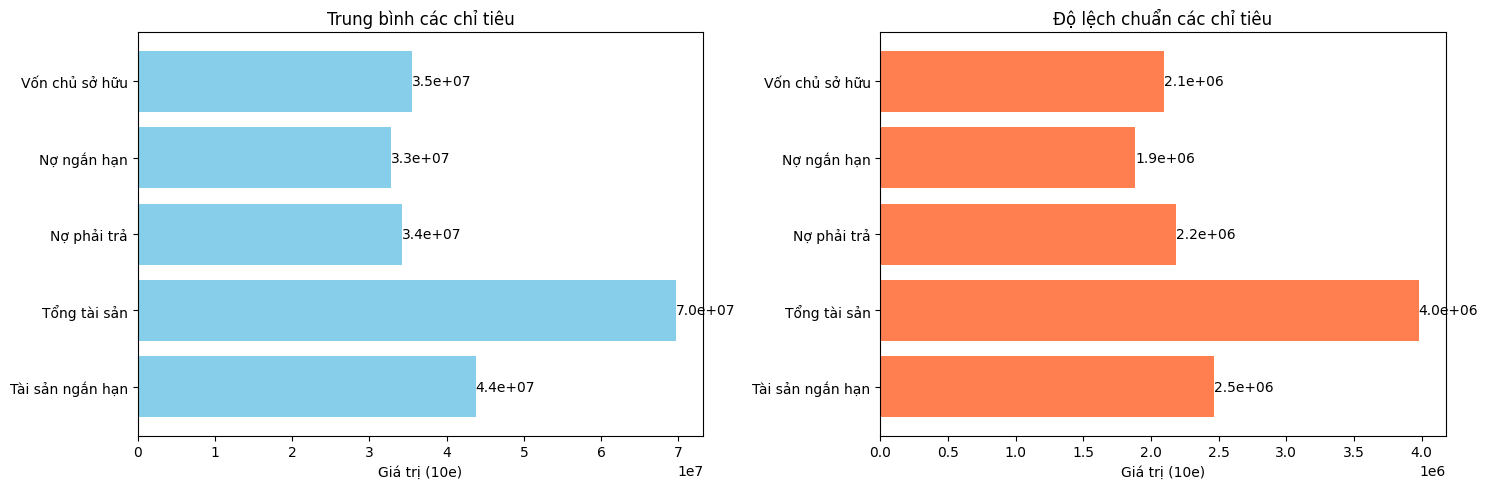

In [102]:
import matplotlib.pyplot as plt
import numpy as np

# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(15, 5))  # Adjust figsize for desired width and height

# # Data for plotting
indicators = df["Chỉ tiêu"]
mean_values = df["Trung bình"]
std_values = df["Độ lệch chuẩn"]

# # Plot Mean values
axes[0].barh(indicators, mean_values, color='skyblue')
axes[0].set_title('Trung bình các chỉ tiêu')
axes[0].set_xlabel('Giá trị (10e)')

# # Add values next to bars for Mean
for i, v in enumerate(mean_values):
     axes[0].text(v, i, f'{v:.1e}', color='black', va='center')

# # Plot Standard Deviation values
axes[1].barh(indicators, std_values, color='coral')
axes[1].set_title('Độ lệch chuẩn các chỉ tiêu')
axes[1].set_xlabel('Giá trị (10e)')

# # Add values next to bars for Standard Deviation
for i, v in enumerate(std_values):
     axes[1].text(v, i, f'{v:.1e}', color='black', va='center')

# # Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [103]:
#xem xét sự biến động của các chỉ tiêu
df["Tỷ lệ biến động (%)"] = df["Độ lệch chuẩn"] / df["Trung bình"] * 100
df["Tỷ lệ biến động (%)"] = df["Tỷ lệ biến động (%)"].round(2)
df

,Chỉ tiêu,Trung bình,Độ lệch chuẩn,Tỷ lệ biến động (%)
0,Tài sản ngắn hạn,43744817.25,2.467281e+06,5.64
1,Tổng tài sản,69728616.50,3.977965e+06,5.70
2,Nợ phải trả,34268190.00,2.187528e+06,6.38
3,Nợ ngắn hạn,32752070.50,1.883142e+06,5.75
4,Vốn chủ sở hữu,35460426.25,2.099165e+06,5.92


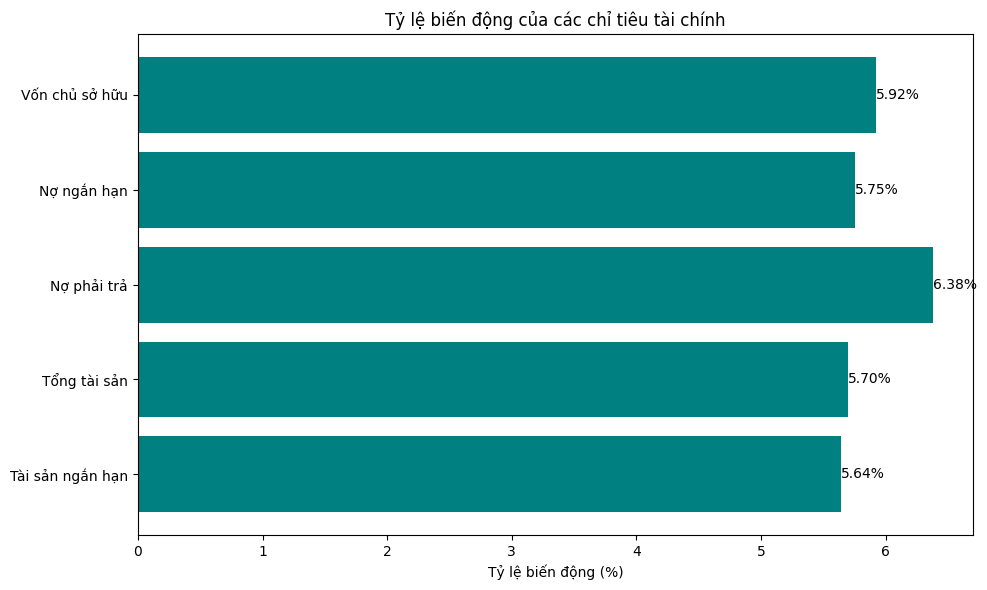

In [104]:
import matplotlib.pyplot as plt
import numpy as np

# Data for plotting
indicators = df["Chỉ tiêu"]
variability_percentage = df["Tỷ lệ biến động (%)"]

# Create the plot
plt.figure(figsize=(10, 6))  # Adjust figsize as needed
plt.barh(indicators, variability_percentage, color='teal')
plt.xlabel('Tỷ lệ biến động (%)')
plt.title('Tỷ lệ biến động của các chỉ tiêu tài chính')

# Add values next to bars
for i, v in enumerate(variability_percentage):
    plt.text(v, i, f'{v:.2f}%', color='black', va='center')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

### 📊 Tỷ lệ biến động các chỉ tiêu tài chính

| Chỉ tiêu            | Biến động (%) |
|---------------------|---------------|
| Nợ phải trả         | **6.38%**     |
| Vốn chủ sở hữu      | 5.92%         |
| Nợ ngắn hạn         | 5.75%         |
| Tổng tài sản        | 5.70%         |
| Tài sản ngắn hạn    | 5.64%         |

#### 🔍 Nhận xét:
- **Nợ phải trả tăng mạnh nhất**, cho thấy doanh nghiệp gia tăng sử dụng đòn bẩy tài chính.
- **Vốn chủ sở hữu tăng ổn định**, phản ánh tình hình tài chính tích cực.
- **Tổng tài sản & tài sản ngắn hạn tăng đều**, cho thấy doanh nghiệp mở rộng quy mô.
- Cần theo dõi rủi ro tài chính nếu tỷ lệ nợ tiếp tục tăng cao hơn vốn.

#### 🧠 Kết luận:
> Doanh nghiệp đang tăng trưởng đồng đều, nhưng cần chú ý đến mức tăng của nợ để đảm bảo an toàn tài chính.


## III.Phân tích xu hướng tài chính theo thời gian

## 3.1 Chuẩn bị dữ liệu để phân tích

In [105]:
can_doi_KT

,Quý 2/202401/04-30/06CKT/HN,Quý 3/202401/07-30/09CKT/HN,Quý 4/202401/10-31/12CKT/HN,Quý 1/202501/01-31/03CKT/HN
Cân đối kế toán,,,,
Tài sản ngắn hạn,40823156,42605106,45475496,46075511
Tổng tài sản,65321968,67581587,72013238,73997673
Nợ phải trả,32537727,32217403,36216612,36101018
Nợ ngắn hạn,31341216,30969637,34780312,33917117
Vốn chủ sở hữu,32784240,35364184,35796626,37896655


In [106]:
#Xem xét các thông tin cơ bản của bảng cân đối kế toán
can_doi_KT.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5 entries, Tài sản ngắn hạn to Vốn chủ sở hữu
Data columns (total 4 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   Quý 2/202401/04-30/06CKT/HN  5 non-null      int64
 1   Quý 3/202401/07-30/09CKT/HN  5 non-null      int64
 2   Quý 4/202401/10-31/12CKT/HN  5 non-null      int64
 3   Quý 1/202501/01-31/03CKT/HN  5 non-null      int64
dtypes: int64(4)
memory usage: 372.0+ bytes


In [91]:
#Tính % thay đổi giữa các năm
can_doi_KT_change= can_doi_KT.pct_change(axis=1)*100
can_doi_KT_change=can_doi_KT_change.round(2)
can_doi_KT_change


,Quý 2/202401/04-30/06CKT/HN,Quý 3/202401/07-30/09CKT/HN,Quý 4/202401/10-31/12CKT/HN,Quý 1/202501/01-31/03CKT/HN
Cân đối kế toán,,,,
Tài sản ngắn hạn,NaN,4.37,6.74,1.32
Tổng tài sản,NaN,3.46,6.56,2.76
Nợ phải trả,NaN,-0.98,12.41,-0.32
Nợ ngắn hạn,NaN,-1.19,12.30,-2.48
Vốn chủ sở hữu,NaN,7.87,1.22,5.87


## 3.2 TRực quan hóa dữ liệu

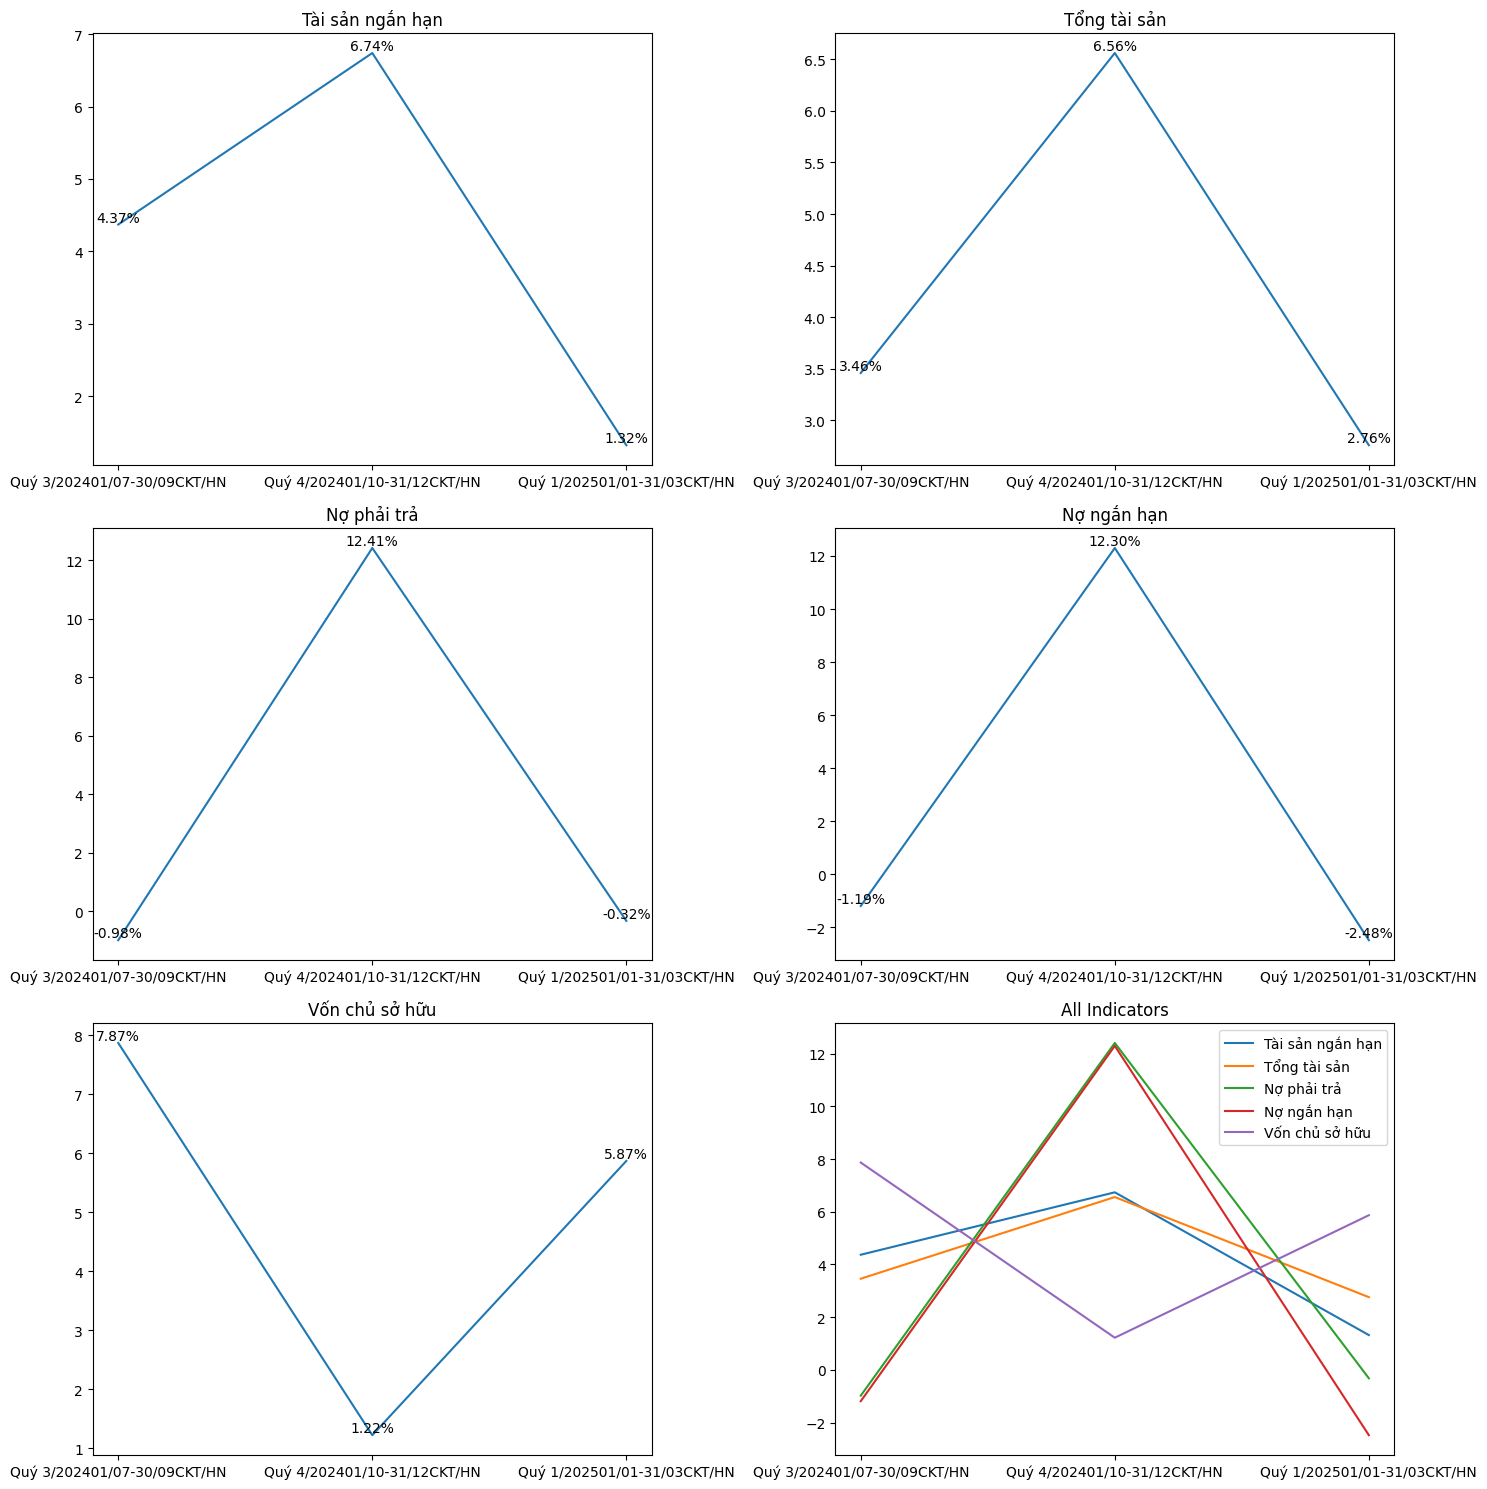

In [107]:
import matplotlib.pyplot as plt
import numpy as np

# Get the first 5 indicators from the index
indicators = can_doi_KT_change.index[:5]

# Create a subplot with 3 rows and 2 columns
fig, axes = plt.subplots(3, 2, figsize=(15, 15))  # Adjust figsize for desired width and height

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Plot individual line charts for the first 5 indicators
for i, indicator in enumerate(indicators):
    ax = axes[i]
    data = can_doi_KT_change.loc[indicator]
    ax.plot(data.index, data.values)
    ax.set_title(indicator)

    # Add percentage values above the lines
    for x, y in zip(data.index, data.values):
        ax.text(x, y, f'{y:.2f}%', ha='center', va='bottom')

# Plot all 5 indicators in the 6th subplot
ax = axes[5]
for indicator in indicators:
    data = can_doi_KT_change.loc[indicator]
    ax.plot(data.index, data.values, label=indicator)

ax.set_title('All Indicators')
ax.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

## 3.3 Kết luận

## 📊 Tóm tắt Kết luận Phân tích Biểu đồ Tài chính

### 1. Tăng trưởng mạnh trong Quý 4/2024
- Các chỉ số như **Tài sản ngắn hạn**, **Tổng tài sản**, **Nợ phải trả** và **Nợ ngắn hạn** đều tăng mạnh, đạt đỉnh trong quý này.
- **Nợ phải trả** và **Nợ ngắn hạn** lần lượt đạt `12.41%` và `12.30%` → Doanh nghiệp có thể đã tăng vay nợ để mở rộng hoạt động.

### 2. Suy giảm rõ rệt trong Quý 1/2025
- Các chỉ số chính giảm mạnh:  
  - *Tài sản ngắn hạn*: `1.27%`  
  - *Tổng tài sản*: `2.68%`  
  - *Nợ phải trả*: `-0.72%`  
- → Có thể doanh nghiệp đã thanh toán hoặc tái cơ cấu nợ.

### 3. Vốn chủ sở hữu duy trì ổn định hơn
- Giảm trong Quý 4/2024 xuống `1.12%`, nhưng **phục hồi lên** `5.87%` ở Quý 1/2025.
- → Cho thấy cổ đông vẫn duy trì giá trị đầu tư hoặc doanh nghiệp giữ lại lợi nhuận.

---

### ✅ Tổng kết
> Doanh nghiệp tăng trưởng mạnh cuối năm 2024 nhưng giảm sút đầu năm 2025. Đây có thể là do yếu tố thời vụ hoặc thay đổi chiến lược.  
> **Khuyến nghị**: Cần theo dõi thêm các quý sau để xác định xu hướng bền vững.


## IV. Phân tích cơ cấu tài chính

## 4.1 Chuẩn bị dữ liệu để phân tích

In [108]:
can_doi_KT

,Quý 2/202401/04-30/06CKT/HN,Quý 3/202401/07-30/09CKT/HN,Quý 4/202401/10-31/12CKT/HN,Quý 1/202501/01-31/03CKT/HN
Cân đối kế toán,,,,
Tài sản ngắn hạn,40823156,42605106,45475496,46075511
Tổng tài sản,65321968,67581587,72013238,73997673
Nợ phải trả,32537727,32217403,36216612,36101018
Nợ ngắn hạn,31341216,30969637,34780312,33917117
Vốn chủ sở hữu,32784240,35364184,35796626,37896655


In [109]:
can_doi_copy=can_doi_KT.copy()
can_doi_copy

,Quý 2/202401/04-30/06CKT/HN,Quý 3/202401/07-30/09CKT/HN,Quý 4/202401/10-31/12CKT/HN,Quý 1/202501/01-31/03CKT/HN
Cân đối kế toán,,,,
Tài sản ngắn hạn,40823156,42605106,45475496,46075511
Tổng tài sản,65321968,67581587,72013238,73997673
Nợ phải trả,32537727,32217403,36216612,36101018
Nợ ngắn hạn,31341216,30969637,34780312,33917117
Vốn chủ sở hữu,32784240,35364184,35796626,37896655


In [110]:
#Tính tỉ trọng % trên tổng tài sản
can_doi_copy_pct=can_doi_copy.div(can_doi_copy.loc["Tổng tài sản"])*100
can_doi_copy_pct

,Quý 2/202401/04-30/06CKT/HN,Quý 3/202401/07-30/09CKT/HN,Quý 4/202401/10-31/12CKT/HN,Quý 1/202501/01-31/03CKT/HN
Cân đối kế toán,,,,
Tài sản ngắn hạn,62.495294,63.042476,63.148801,62.266162
Tổng tài sản,100.000000,100.000000,100.000000,100.000000
Nợ phải trả,49.811309,47.671865,50.291603,48.786694
Nợ ngắn hạn,47.979595,45.825555,48.297109,45.835383
Vốn chủ sở hữu,50.188690,52.328135,49.708397,51.213306


In [111]:
#Làm tròn về 2 chữ số sau phần thập phân và bỏ hàng "Tổng tài sản "
can_doi_copy_pct=can_doi_copy_pct.round(2)
can_doi_copy_pct=can_doi_copy_pct.drop("Tổng tài sản")
can_doi_copy_pct

,Quý 2/202401/04-30/06CKT/HN,Quý 3/202401/07-30/09CKT/HN,Quý 4/202401/10-31/12CKT/HN,Quý 1/202501/01-31/03CKT/HN
Cân đối kế toán,,,,
Tài sản ngắn hạn,62.50,63.04,63.15,62.27
Nợ phải trả,49.81,47.67,50.29,48.79
Nợ ngắn hạn,47.98,45.83,48.30,45.84
Vốn chủ sở hữu,50.19,52.33,49.71,51.21


## 4.2 TRực quan hóa dữ liệu

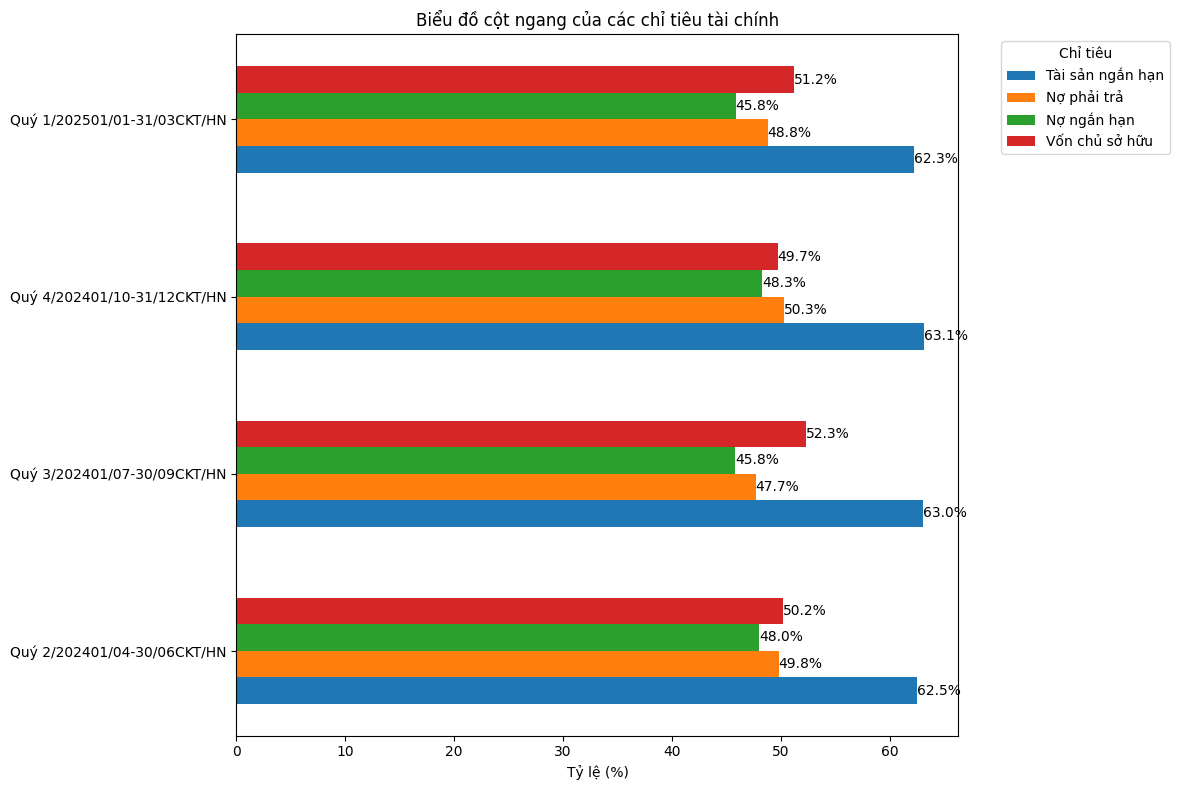

In [112]:
import matplotlib.pyplot as plt
import numpy as np

# Transpose the DataFrame for plotting
data_to_plot = can_doi_copy_pct.T

# Get the years (column names) and indicators (index)
years = data_to_plot.columns
indicators = data_to_plot.index

# Create the horizontal bar chart
fig, ax = plt.subplots(figsize=(12, 8))  # Adjust figsize as needed

# Plot bars for each year
bar_width = 0.15  # Adjust for spacing between bars
year_positions = np.arange(len(years))

for i, year in enumerate(years):
    ax.barh(year_positions + i * bar_width, data_to_plot[year], height=bar_width, label=year)

    # Add percentage labels on top of bars
    for j, value in enumerate(data_to_plot[year]):
        ax.text(value, year_positions[j] + i * bar_width, f'{value:.1f}%',
                ha='left', va='center', color='black')

# Set labels and title
ax.set_yticks(year_positions + bar_width * (len(years) - 1) / 2)
ax.set_yticklabels(indicators)
ax.set_xlabel('Tỷ lệ (%)')  # X-axis label
ax.set_title('Biểu đồ cột ngang của các chỉ tiêu tài chính')  # Chart title
ax.legend(title = "Chỉ tiêu", bbox_to_anchor = (1.05,1), loc = "upper left")

plt.tight_layout()
plt.show()

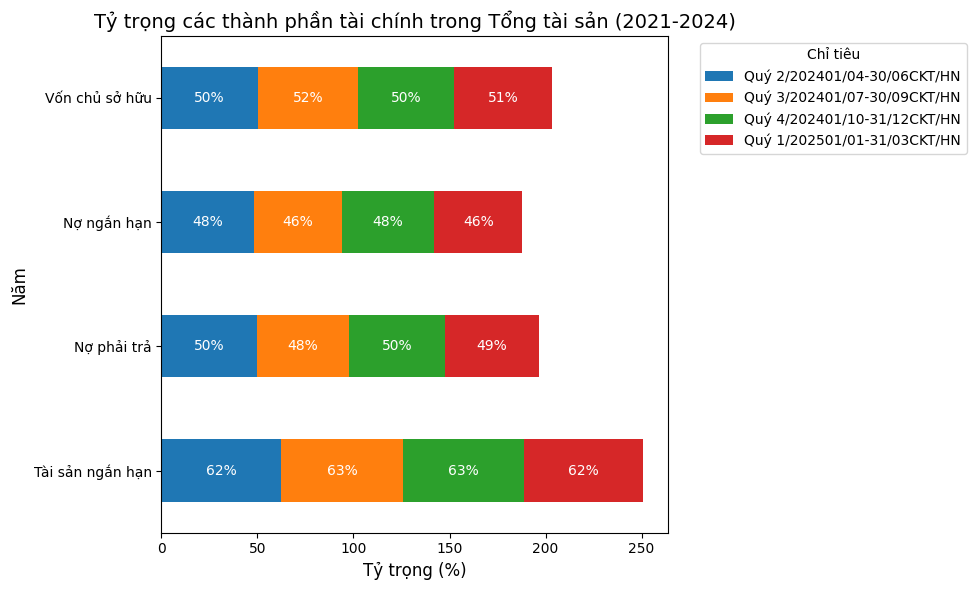

In [113]:
# Vẽ biểu đồ stacked bar chart ngang để thể hiện tỉ trọng các thành phần tài chính qua các năm
ax = can_doi_copy_pct.plot(kind='barh', stacked=True, figsize=(10, 6))

# Thêm giá trị tỷ trọng (%) vào từng thanh
for p in ax.patches:
    width = p.get_width()  # Lấy chiều rộng của thanh (tương đương tỷ trọng phần trăm)
    height = p.get_height()  # Lấy chiều cao của thanh
    y = p.get_y() + height / 2  # Vị trí Y của nhãn
    x = p.get_x() + width / 2  # Vị trí X của nhãn
    ax.text(x, y, f'{width:.0f}%', ha='center', va='center', fontsize=10, color='white')

# Tùy chỉnh thêm cho biểu đồ
plt.title('Tỷ trọng các thành phần tài chính trong Tổng tài sản (2021-2024)', fontsize=14)
plt.xlabel('Tỷ trọng (%)', fontsize=12)
plt.ylabel('Năm', fontsize=12)
plt.legend(title='Chỉ tiêu', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()  # Đảm bảo các nhãn không bị che
plt.show()

## 4.3 Nhận xét

## 📊 Nhận xét ngắn gọn

- **Tài sản ngắn hạn** luôn chiếm tỷ trọng cao (~62–63%), cho thấy doanh nghiệp có tính thanh khoản tốt.
- **Vốn chủ sở hữu** và **nợ phải trả** duy trì ổn định quanh mức 50%, thể hiện cơ cấu tài chính cân đối.
- **Nợ ngắn hạn** chiếm khoảng 46–48%, không biến động nhiều, cho thấy áp lực trả nợ ngắn hạn được kiểm soát.


## V. Hiệu quả sinh lời (ROA,ROE,ROS)

## 5.1 Chuẩn bị dữ liệu để phân tích

In [114]:
chi_so_TC

,Chỉ số tài chính,Quý 2/202401/04-30/06CKT/HN,Quý 3/202401/07-30/09CKT/HN,Quý 4/202401/10-31/12CKT/HN,Quý 1/202501/01-31/03CKT/HN
0,EPS 4 quý,561800,565200,569700,577200
1,BVPS cơ bản,2244600,2421300,2433200,2575900
2,P/E cơ bản,2323,2380,2677,2096
3,ROS,1498,1559,1416,1616
4,ROEA,581,613,587,591
5,ROAA,294,314,299,298


In [115]:
# Lọc các chỉ số sinh lời từ bảng chỉ số tài chính
chi_so_loi_nhuan=chi_so_TC.set_index("Chỉ số tài chính").loc[["ROS","ROEA","ROAA"]]
chi_so_loi_nhuan

,Quý 2/202401/04-30/06CKT/HN,Quý 3/202401/07-30/09CKT/HN,Quý 4/202401/10-31/12CKT/HN,Quý 1/202501/01-31/03CKT/HN
Chỉ số tài chính,,,,
ROS,1498,1559,1416,1616
ROEA,581,613,587,591
ROAA,294,314,299,298


## 5.2 TRực quan hóa dữ liệu

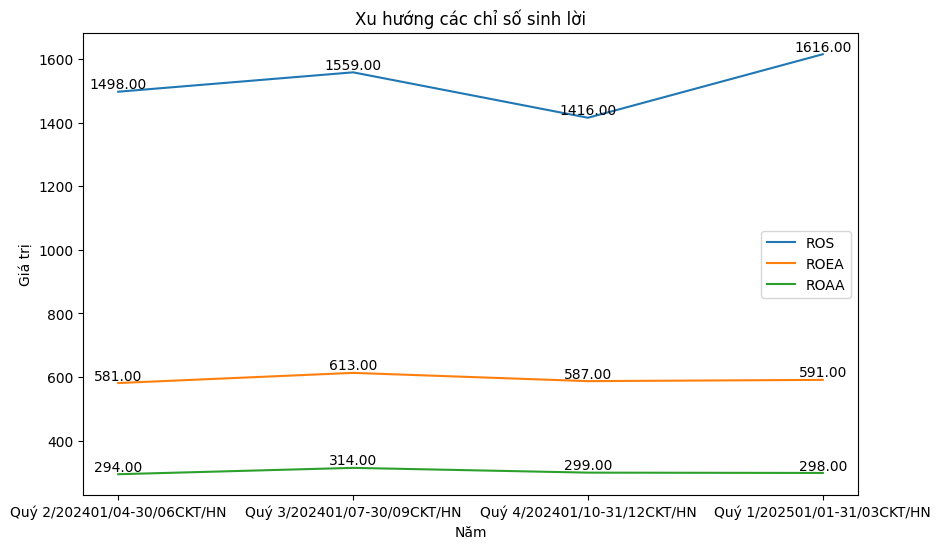

In [116]:
import matplotlib.pyplot as plt

# Transpose the DataFrame for easier plotting
chi_so_loi_nhuan_transposed = chi_so_loi_nhuan.T

# Chuyển tất cả giá trị sang kiểu float
chi_so_loi_nhuan_transposed = chi_so_loi_nhuan_transposed.astype(float)

# Create the line chart
plt.figure(figsize=(10, 6))  # Adjust figure size if needed

for indicator in chi_so_loi_nhuan_transposed.columns:
    plt.plot(chi_so_loi_nhuan_transposed.index, chi_so_loi_nhuan_transposed[indicator], label=indicator)
    # Add values on the lines
    for x, y in zip(chi_so_loi_nhuan_transposed.index, chi_so_loi_nhuan_transposed[indicator]):
        plt.text(x, y, f'{y:.2f}', ha='center', va='bottom')

# Customize the chart
plt.xlabel("Năm")
plt.ylabel("Giá trị")
plt.title("Xu hướng các chỉ số sinh lời")
plt.legend()
plt.show()


## 📈 Nhận xét: Xu hướng các chỉ số sinh lời (ROS, ROEA, ROAA)

### 1. ROS (Return on Sales)
- Tăng từ **1498** (Quý 2/2024) lên **1616** (Quý 1/2025).
- Có giảm nhẹ ở Quý 4/2024 nhưng sau đó phục hồi mạnh.
- → Hiệu quả sinh lời từ doanh thu được cải thiện về cuối kỳ.

### 2. ROEA (Return on Equity Average)
- Dao động nhẹ trong khoảng **581–613**, với đỉnh ở Quý 3/2024.
- Biến động không lớn → Doanh nghiệp duy trì ổn định khả năng sinh lời trên vốn chủ sở hữu.

### 3. ROAA (Return on Assets Average)
- Ổn định quanh mức **294–314**, ít biến động nhất.
- → Hiệu quả sử dụng tài sản không thay đổi nhiều qua các quý.

---

### ✅ Tổng kết
> ROS tăng mạnh cho thấy biên lợi nhuận cải thiện.  
> ROEA và ROAA ổn định → Cơ cấu tài chính và khả năng sinh lời từ vốn và tài sản duy trì bền vững.


## VI Phân tích khả năng thanh toán

## 6.1 Chuẩn bị dữ liệu để phân tích

In [117]:
#Tạo bảng bóc tách các chỉ số
can_doi_tt=can_doi_KT.copy()
can_doi_tt

,Quý 2/202401/04-30/06CKT/HN,Quý 3/202401/07-30/09CKT/HN,Quý 4/202401/10-31/12CKT/HN,Quý 1/202501/01-31/03CKT/HN
Cân đối kế toán,,,,
Tài sản ngắn hạn,40823156,42605106,45475496,46075511
Tổng tài sản,65321968,67581587,72013238,73997673
Nợ phải trả,32537727,32217403,36216612,36101018
Nợ ngắn hạn,31341216,30969637,34780312,33917117
Vốn chủ sở hữu,32784240,35364184,35796626,37896655


In [118]:
#Bóc tách từng hàng chỉ tiêu để tính toán
TSNH=can_doi_tt.loc["Tài sản ngắn hạn"]
TSNH

,Tài sản ngắn hạn
Quý 2/202401/04-30/06CKT/HN,40823156
Quý 3/202401/07-30/09CKT/HN,42605106
Quý 4/202401/10-31/12CKT/HN,45475496
Quý 1/202501/01-31/03CKT/HN,46075511


In [119]:
NNH = can_doi_tt.loc["Nợ ngắn hạn"]
TTS = can_doi_tt.loc["Tổng tài sản"]
NPT = can_doi_tt.loc["Nợ phải trả"]

In [120]:
#Áp dụng các công thức
#Tính hệ số thanh toán hiện hành
current_ratio=TSNH/NNH
current_ratio

,0
Quý 2/202401/04-30/06CKT/HN,1.302539
Quý 3/202401/07-30/09CKT/HN,1.375706
Quý 4/202401/10-31/12CKT/HN,1.307507
Quý 1/202501/01-31/03CKT/HN,1.358474


In [121]:
#Hệ số nợ trên tài sản
debt_to_asset_ratio=NPT/TTS
debt_to_asset_ratio

,0
Quý 2/202401/04-30/06CKT/HN,0.498113
Quý 3/202401/07-30/09CKT/HN,0.476719
Quý 4/202401/10-31/12CKT/HN,0.502916
Quý 1/202501/01-31/03CKT/HN,0.487867


In [122]:
#Tổng hợp các chỉ số
df_thanh_toan=pd.DataFrame(
    {
        "Hệ số thanh toán hiện hành":current_ratio,
        "Hệ số nợ trên tài sản":debt_to_asset_ratio
    }
)
df_thanh_toan

,Hệ số thanh toán hiện hành,Hệ số nợ trên tài sản
Quý 2/202401/04-30/06CKT/HN,1.302539,0.498113
Quý 3/202401/07-30/09CKT/HN,1.375706,0.476719
Quý 4/202401/10-31/12CKT/HN,1.307507,0.502916
Quý 1/202501/01-31/03CKT/HN,1.358474,0.487867


In [123]:
df_thanh_toan=df_thanh_toan.T
df_thanh_toan

,Quý 2/202401/04-30/06CKT/HN,Quý 3/202401/07-30/09CKT/HN,Quý 4/202401/10-31/12CKT/HN,Quý 1/202501/01-31/03CKT/HN
Hệ số thanh toán hiện hành,1.302539,1.375706,1.307507,1.358474
Hệ số nợ trên tài sản,0.498113,0.476719,0.502916,0.487867


## 6.2 TRực quan hóa dữ liệu

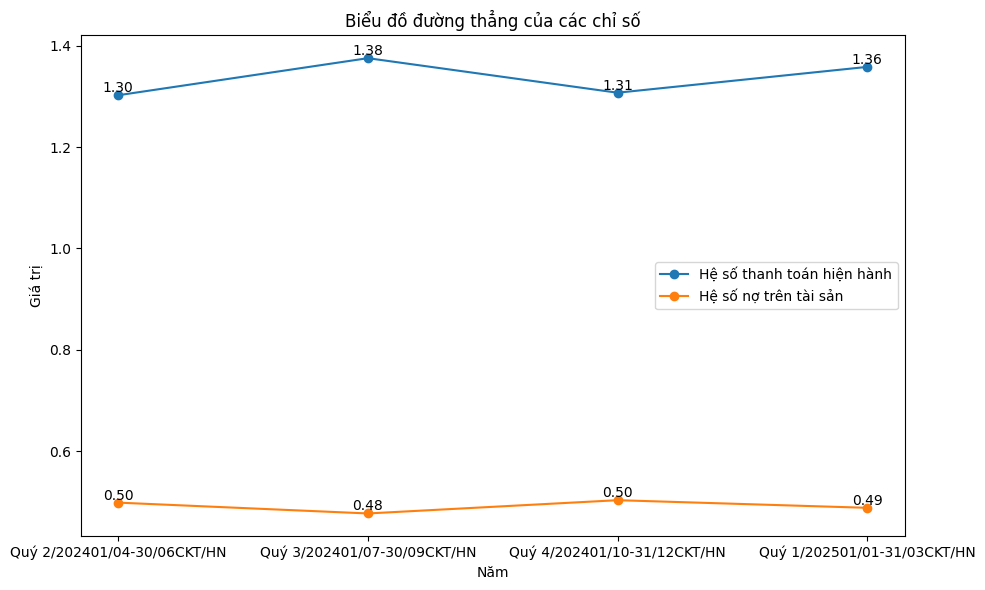

In [124]:
# Create the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))  # Adjust figsize for desired width and height


# Plot each category (index item) as a line
for category in df_thanh_toan.index:
    ax.plot(df_thanh_toan.columns, df_thanh_toan.loc[category], label=category, marker='o') # Use markers like 'o' for data points

    # Display values on the lines (rounded to 2 decimal places)
    for x, y in zip(df_thanh_toan.columns, df_thanh_toan.loc[category]):
        ax.text(x, y, f'{y:.2f}', ha='center', va='bottom') # 'ha' and 'va' for text alignment

# Set plot labels and title
ax.set_xlabel('Năm')
ax.set_ylabel('Giá trị')
ax.set_title('Biểu đồ đường thẳng của các chỉ số')
ax.legend()  # Display the legend to show category labels


# Show the plot
plt.tight_layout()
plt.show()

## 6.3 Nhận xét

## 📊 Nhận xét: Biểu đồ hệ số thanh toán & hệ số nợ trên tài sản

### 1. Hệ số thanh toán hiện hành
- Tăng nhẹ từ **1.30** (Quý 2/2024) lên **1.38** (Quý 3/2024), sau đó giảm xuống **1.31** và phục hồi lại ở mức **1.36**.
- → Cho thấy khả năng thanh toán ngắn hạn của doanh nghiệp **duy trì ổn định và ở mức an toàn** (>1).

### 2. Hệ số nợ trên tài sản
- Dao động rất nhẹ quanh mức **0.48–0.50**, cho thấy tỷ lệ nợ chiếm khoảng **49–50% tổng tài sản**.
- → Cơ cấu tài chính tương đối an toàn, không có dấu hiệu tăng rủi ro nợ.

---

### ✅ Tổng kết
> Doanh nghiệp có **khả năng thanh toán tốt**, cùng với **cơ cấu vốn ổn định**.  
> Biểu đồ phản ánh sự **an toàn tài chính** và kiểm soát tốt nợ trong giai đoạn 2024–2025.


## VII. Phân tích giá trị cổ phiếu (EPS,P/E,BVPS)

## 7.1 Chuẩn bị dữ liệu

In [125]:
chi_so_TC

,Chỉ số tài chính,Quý 2/202401/04-30/06CKT/HN,Quý 3/202401/07-30/09CKT/HN,Quý 4/202401/10-31/12CKT/HN,Quý 1/202501/01-31/03CKT/HN
0,EPS 4 quý,561800,565200,569700,577200
1,BVPS cơ bản,2244600,2421300,2433200,2575900
2,P/E cơ bản,2323,2380,2677,2096
3,ROS,1498,1559,1416,1616
4,ROEA,581,613,587,591
5,ROAA,294,314,299,298


In [126]:
#Lọc các chỉ số cổ phiếu
chi_so_co_dong=chi_so_TC.set_index("Chỉ số tài chính").loc[["EPS 4 quý","BVPS cơ bản","P/E cơ bản"]]
chi_so_co_dong

,Quý 2/202401/04-30/06CKT/HN,Quý 3/202401/07-30/09CKT/HN,Quý 4/202401/10-31/12CKT/HN,Quý 1/202501/01-31/03CKT/HN
Chỉ số tài chính,,,,
EPS 4 quý,561800,565200,569700,577200
BVPS cơ bản,2244600,2421300,2433200,2575900
P/E cơ bản,2323,2380,2677,2096


## 7.2 TRực quan hóa dữ liệu

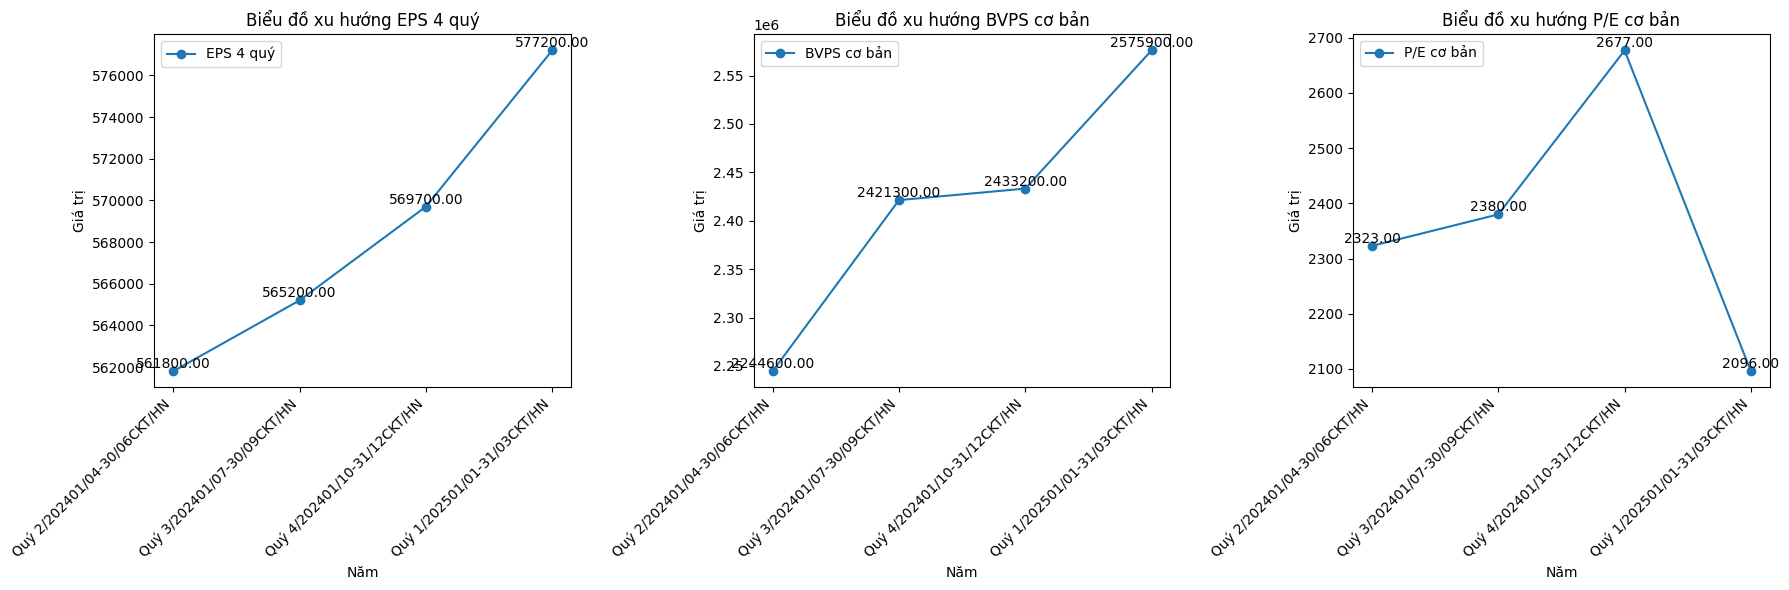

In [127]:
import matplotlib.pyplot as plt

# Chuyển toàn bộ dữ liệu sang float
chi_so_co_dong = chi_so_co_dong.astype(float)

fig, axes = plt.subplots(1, len(chi_so_co_dong), figsize=(6 * len(chi_so_co_dong), 6))

# Đảm bảo axes luôn là list
if len(chi_so_co_dong) == 1:
    axes = [axes]

for i, indicator in enumerate(chi_so_co_dong.index):
    ax = axes[i]
    ax.plot(chi_so_co_dong.columns, chi_so_co_dong.loc[indicator], marker='o', label=indicator)

    for x, y in zip(chi_so_co_dong.columns, chi_so_co_dong.loc[indicator]):
        ax.text(x, y, f'{y:.2f}', ha='center', va='bottom')

    ax.set_xlabel("Năm")
    ax.set_ylabel("Giá trị")
    ax.set_title(f"Biểu đồ xu hướng {indicator}")
    ax.legend()

    # ✅ Xoay nhãn trục X để tránh chồng
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()


## 7.3 Kết luận

## 📊 Nhận xét ngắn gọn

- **EPS 4 quý** tăng đều → Lợi nhuận cải thiện ổn định.
- **BVPS cơ bản** tăng nhẹ → Giá trị cổ đông được nâng cao.
- **P/E cơ bản** biến động mạnh → Thị trường điều chỉnh kỳ vọng định giá.

---

### ✅ Tổng kết
> Doanh nghiệp duy trì hiệu quả hoạt động tốt, tuy nhiên sự biến động P/E cho thấy cần theo dõi thêm yếu tố thị trường ảnh hưởng đến định giá cổ phiếu.


## VIII. Tương quan giữa các chỉ số tài chính

In [128]:
ket_qua_KD

,Kết quả kinh doanh,Quý 2/202401/04-30/06CKT/HN,Quý 3/202401/07-30/09CKT/HN,Quý 4/202401/10-31/12CKT/HN,Quý 1/202501/01-31/03CKT/HN
0,Doanh thu thuần,15245226,15902822,17607818,16058141
1,Lợi nhuận gộp,5651357,6158956,6478973,6301348
2,LN thuần từ HĐKD,2635781,2948226,2922047,2993843
3,LNST thu nhập DN,2283041,2478598,2493502,2595557
4,LNST của CĐ cty mẹ,1873815,2088852,2086993,2174301


In [129]:
can_doi_KT

,Quý 2/202401/04-30/06CKT/HN,Quý 3/202401/07-30/09CKT/HN,Quý 4/202401/10-31/12CKT/HN,Quý 1/202501/01-31/03CKT/HN
Cân đối kế toán,,,,
Tài sản ngắn hạn,40823156,42605106,45475496,46075511
Tổng tài sản,65321968,67581587,72013238,73997673
Nợ phải trả,32537727,32217403,36216612,36101018
Nợ ngắn hạn,31341216,30969637,34780312,33917117
Vốn chủ sở hữu,32784240,35364184,35796626,37896655


In [130]:
#Chuẩn hóa dữ liệu:Chuyển đổi cột chỉ tiêu ở bảng kết quả kinh doanh thành index còn lại sao chép bảng KT
ket_qua=ket_qua_KD.set_index("Kết quả kinh doanh")
can_doi=can_doi_KT.copy()

In [131]:
ket_qua

,Quý 2/202401/04-30/06CKT/HN,Quý 3/202401/07-30/09CKT/HN,Quý 4/202401/10-31/12CKT/HN,Quý 1/202501/01-31/03CKT/HN
Kết quả kinh doanh,,,,
Doanh thu thuần,15245226,15902822,17607818,16058141
Lợi nhuận gộp,5651357,6158956,6478973,6301348
LN thuần từ HĐKD,2635781,2948226,2922047,2993843
LNST thu nhập DN,2283041,2478598,2493502,2595557
LNST của CĐ cty mẹ,1873815,2088852,2086993,2174301


In [132]:
can_doi

,Quý 2/202401/04-30/06CKT/HN,Quý 3/202401/07-30/09CKT/HN,Quý 4/202401/10-31/12CKT/HN,Quý 1/202501/01-31/03CKT/HN
Cân đối kế toán,,,,
Tài sản ngắn hạn,40823156,42605106,45475496,46075511
Tổng tài sản,65321968,67581587,72013238,73997673
Nợ phải trả,32537727,32217403,36216612,36101018
Nợ ngắn hạn,31341216,30969637,34780312,33917117
Vốn chủ sở hữu,32784240,35364184,35796626,37896655


In [133]:
#Lấy các chỉ tiêu cần phân tích tương quan
bien_tc=pd.concat(
    [
        ket_qua.loc[["Doanh thu thuần","LNST thu nhập DN"]],
        can_doi.loc[["Tổng tài sản","Nợ phải trả","Vốn chủ sở hữu"]]
    ]
)

In [134]:
bien_tc=bien_tc.T
bien_tc

,Doanh thu thuần,LNST thu nhập DN,Tổng tài sản,Nợ phải trả,Vốn chủ sở hữu
Quý 2/202401/04-30/06CKT/HN,15245226,2283041,65321968,32537727,32784240
Quý 3/202401/07-30/09CKT/HN,15902822,2478598,67581587,32217403,35364184
Quý 4/202401/10-31/12CKT/HN,17607818,2493502,72013238,36216612,35796626
Quý 1/202501/01-31/03CKT/HN,16058141,2595557,73997673,36101018,37896655


In [135]:
#tạo pearson: Tương quan tuyến tính
corr_pearson=bien_tc.corr(method="pearson")
corr_pearson

,Doanh thu thuần,LNST thu nhập DN,Tổng tài sản,Nợ phải trả,Vốn chủ sở hữu
Doanh thu thuần,1.000000,0.488356,0.624585,0.722755,0.430423
LNST thu nhập DN,0.488356,1.000000,0.895464,0.679093,0.989247
Tổng tài sản,0.624585,0.895464,1.000000,0.931002,0.924831
Nợ phải trả,0.722755,0.679093,0.931002,1.000000,0.722176
Vốn chủ sở hữu,0.430423,0.989247,0.924831,0.722176,1.000000


In [136]:
#Spearman: Tương quan thứ bậc
corr_spearman=bien_tc.corr(method="spearman")
corr_spearman

,Doanh thu thuần,LNST thu nhập DN,Tổng tài sản,Nợ phải trả,Vốn chủ sở hữu
Doanh thu thuần,1.0,0.8,0.8,0.8,0.8
LNST thu nhập DN,0.8,1.0,1.0,0.6,1.0
Tổng tài sản,0.8,1.0,1.0,0.6,1.0
Nợ phải trả,0.8,0.6,0.6,1.0,0.6
Vốn chủ sở hữu,0.8,1.0,1.0,0.6,1.0


## 8.2 Trực quan hóa dữ liệu


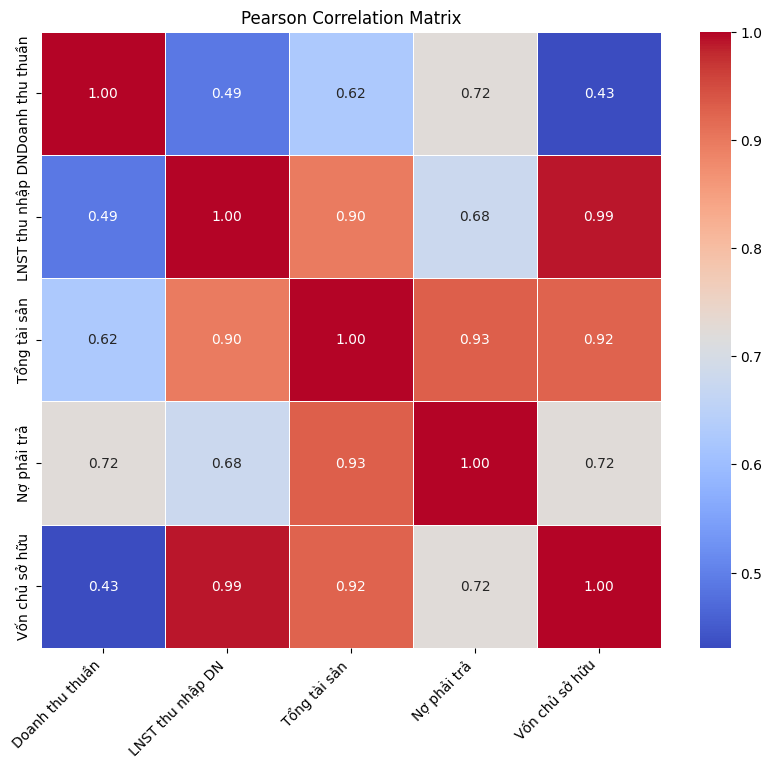

In [137]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'corr_pearson' is your correlation matrix
plt.figure(figsize=(10, 8))  # Adjust figure size if needed
sns.heatmap(corr_pearson, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Pearson Correlation Matrix')
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability if they are long.
plt.show()

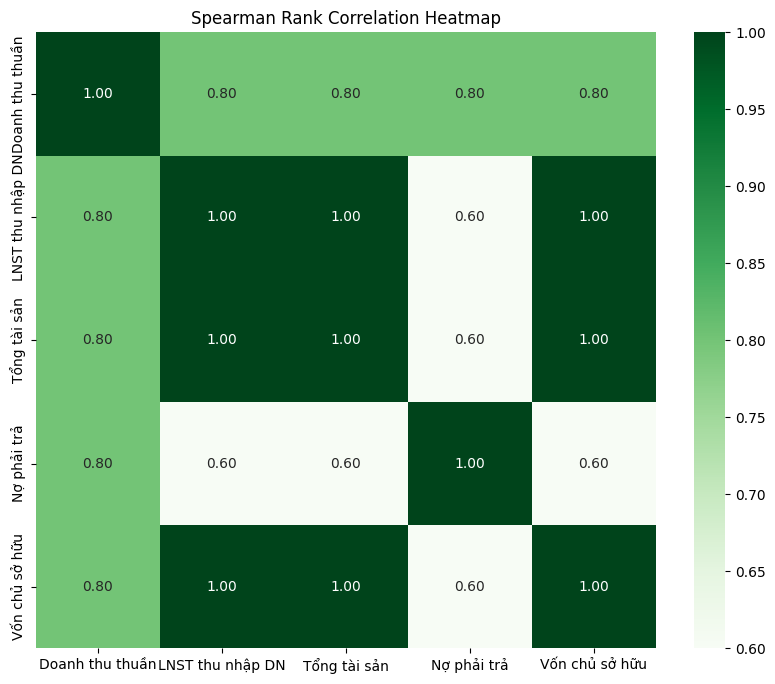

In [138]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'corr_spearman' is your Spearman correlation DataFrame
plt.figure(figsize=(10, 8))  # Adjust figure size if needed
sns.heatmap(corr_spearman, annot=True, cmap="Greens", fmt=".2f",
            xticklabels=corr_spearman.columns, yticklabels=corr_spearman.index)
plt.title("Spearman Rank Correlation Heatmap")
plt.show()

## 8.3 Nhận xét

# Nhận xét ma trận tương quan Pearson và Spearman

## 1. Tổng quan
- **Pearson**: Đo lường mối quan hệ **tuyến tính**.
- **Spearman**: Đo lường mối quan hệ **đơn điệu** (theo thứ hạng).

## 2. Nhận xét
### Ma trận Spearman
- Hệ số tương quan cao (0.80–1.00), cho thấy liên hệ thứ hạng mạnh.
- Phù hợp với dữ liệu phi tuyến hoặc có ngoại lệ.

### Ma trận Pearson
- Tương quan cao ở một số cặp:
  - "LNST thu nhập DN"–"Vốn chủ sở hữu" (0.99).
  - "Tổng tài sản"–"Nợ phải trả" (0.93).
- Tương quan thấp ở một số cặp, như "Doanh thu thuần"–"Vốn chủ sở hữu" (0.43).
- Phù hợp với dữ liệu chuẩn, mối quan hệ tuyến tính.

## 3. Kết luận
- **Spearman**: Phát hiện liên hệ mạnh, kể cả phi tuyến.
- **Pearson**: Đánh giá mối quan hệ tuyến tính, dễ bị ảnh hưởng bởi ngoại lệ.
- **Khuyến nghị**: Dùng Spearman cho dữ liệu phi tuyến hoặc có ngoại lệ.
- Dữ liệu cho thấy liên hệ thứ hạng mạnh, nhưng không phải tất cả đều tuyến tính.